In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset
from IPython.display import Image
import numpy as np
import os
import glob
import random
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
from skimage.measure import compare_ssim, compare_psnr


#writer = SummaryWriter()
import warnings
warnings.filterwarnings(action='once')


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = %s'%device)
print('torch version = %s'%(torch.__version__))
print('no. of GPUs = %d'%(torch.cuda.device_count()))

batch_size, n_in_channels, img_size = 1, 1, 10 #for toy problem
val_batch_size = 1
#dataloader
from torch.utils.data import DataLoader

#custom dataset class 
class ImageDataset(Dataset):
    def __init__(self, root, transforms_= None, unaligned = True, mode = 'train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files = sorted(glob.glob(os.path.join(root, '%s/groundtruth'% mode) + '/*.*'))


    def __getitem__(self, index):
        if self.unaligned:
            ground_truth = self.transform(Image.fromarray(np.load(self.files[random.randint(0, len(self.files) - 1)])))
        else:
            ground_truth = self.transform(Image.fromarray(np.load(self.files[index % len(self.files)])))
        
        

        return {'ground_truth': ground_truth}

    def __len__(self):
        return len(self.files)
    
transform_train_and_test = [transforms.ToTensor()]
datapath = '../data/l1_toy_data'

#training dataloader: test the performance for unaligned=False, i.e. for aligned/paired data
train_dataloader = DataLoader(ImageDataset(datapath, transforms_=transform_train_and_test, unaligned=False, mode = 'train'),\
                              batch_size = batch_size, shuffle = True) #the samples must be unaligned and shuffled
print('number of minibatches during training = %d'%len(train_dataloader))

#modified sigmoid 
def modified_sigmoid(x, alpha):
    x = 1 + torch.exp(-alpha*x)
    x = torch.div(torch.ones(x.size()).to(device), x)
    return x

device = cpu
torch version = 1.8.0
no. of GPUs = 0
number of minibatches during training = 500


In [2]:
#build a convex discriminator (for 10 x 10 inputs)
n_filters = 5 #was 48 previously
filt_dim = 5
n_layers = 10

class new_model(nn.Module):
    def __init__(self, n_in_channels=1, n_filters=n_filters, filt_dim=filt_dim, n_layers=n_layers):
        super(new_model, self).__init__()
        
        self.n_layers = n_layers
        self.wz = nn.ModuleList([nn.Conv2d(n_filters, n_filters, kernel_size=filt_dim, stride=1, padding=2, bias=True) for i in range(self.n_layers)])
        
        #these layers can have arbitrary weights
        self.wx = nn.ModuleList([nn.Conv2d(n_in_channels, n_filters, kernel_size=filt_dim, stride=1, padding=2, bias=True) for i in range(self.n_layers+1)])
        
        #one final conv layer with nonnegative weights
        self.final_conv2d = nn.Conv2d(n_filters, 1, kernel_size=filt_dim, stride=1, padding=2, bias=True)
        
        #slope of leaky-relu
        self.negative_slope = 0.2 
        
    def forward(self, x):
        z = F.leaky_relu(self.wx[0](x), negative_slope=self.negative_slope)
        for layer in range(self.n_layers):
            z = F.leaky_relu(self.wz[layer](z), negative_slope=self.negative_slope)
        z = self.final_conv2d(z)
#         z_avg = F.avg_pool2d(z, z.size()[2:]).view(z.size()[0], -1)
        
        return z
    

#realize the model: just one net which outputs a small number for true and large for something noisy 
mye = new_model().to(device) 


#manually initialize weights
#the following are initialized with non-negative weights
def initialize_weights(net, n_layers = n_layers, min_val = -0.001, max_val = 0.001):
    for layer in range(n_layers):
        net.wz[layer].weight.data = min_val + (max_val - min_val) * torch.rand(n_filters,n_filters,filt_dim,filt_dim).to(device)
    
    net.final_conv2d.weight.data = min_val + (max_val - min_val) * torch.rand(1,n_filters,filt_dim,filt_dim).to(device)
    return net

mye = initialize_weights(mye)

#for debugging
dummy_input = torch.rand(batch_size, n_in_channels, img_size, img_size).to(device)
mye_output = mye(dummy_input)
print(mye_output.size())

total_params = sum(p.numel() for p in mye.parameters())
print('total number of parameters in MYE = %d'%total_params)

torch.Size([1, 1, 10, 10])
total number of parameters in MYE = 7856


/Users/wdiepeveen/PycharmProjects/Learned-Convex-Prior-Sampling/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
###### FOR DEBUGGING ###### 

#check the contributions of each term in the ACR
noise_sd_for_training_stability = 0.0
for idx, batch in enumerate(train_dataloader):
    ############################################
    images = batch["ground_truth"].to(device) #true images
    batch_size = images.size()[0]

    #true images + slight noise for stability
    real_x = images + noise_sd_for_training_stability*torch.randn(batch_size,n_in_channels,img_size,img_size).to(device) 
    
    #for true image
    mye_output = mye(real_x)
    print('--- response to true image ---')
    print('contribution of the leaky-relu network = %.6f'%torch.sum(mye_output))
    
    break

--- response to true image ---
contribution of the leaky-relu network = 5.008121


/Users/wdiepeveen/PycharmProjects/Learned-Convex-Prior-Sampling/lib/python3.8/site-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


In [4]:
import torch.autograd as autograd

def compute_l1_mye_penalty(net, samples, lamb): # for a general regularizer, we can use a simular function
    # Compute l2 gradient norm loss
    prox = net(samples)
    gradient_penalty = 1./2 * ((samples - prox).view(samples.size(0),-1).norm(2, dim=1) ** 2).mean() 
    # Compute prior loss, i.e., l1 loss
#     samples = samples.view(samples.size(0),-1)
    prior_penalty = (prox.view(samples.size(0),-1)).norm(1, dim=1).mean()
    
    loss = gradient_penalty + lamb * prior_penalty

    return loss, gradient_penalty, lamb * prior_penalty


In [6]:
###########
import itertools
betas = (0.5, 0.99) 

#trained without FoE
#optimizer_acr = torch.optim.Adam(itertools.chain(acr.parameters(),l2_net.parameters()), lr=2*1e-5, betas=betas, weight_decay=0.0)

# #when trained with FoE included
optimizer_mye = torch.optim.Adam(mye.parameters(), lr=2*1e-5, betas=betas, weight_decay=0.0)
scheduler_mye = torch.optim.lr_scheduler.StepLR(optimizer_mye, step_size=20, gamma=0.9)

# proximal map related variables
lamb = 1.
alpha = 1.

noise_sd_for_training_stability = 0.0
n_epochs = 10
num_minibatches = 20 #for display

avg_loss_mye_paired = []

for epoch in np.arange(n_epochs):
    
    #restart scheduler and reset losses
    total_loss = 0.0
    total_gp_loss = 0.0
    total_pp_loss = 0.0
    
    for idx, batch in enumerate(train_dataloader):
        
        ############################################
        images = batch["ground_truth"].to(device) #true images
        batch_size = images.size()[0]
        
        #true images + slight noise for stability
        real_x = images + noise_sd_for_training_stability*torch.randn(batch_size,n_in_channels,img_size,img_size).to(device) 
        
        loss, gp_loss, pp_loss = compute_l1_mye_penalty(mye, real_x, alpha * lamb)
        
        #parameter update
        optimizer_mye.zero_grad()
        loss.backward()
        optimizer_mye.step()
        
        total_loss += loss.item()
        total_gp_loss += gp_loss.item()
        total_pp_loss += pp_loss.item()
        
        #clamp negative weights to 0
#         mye = clamp_weights(mye) 
        #take scheduler steps
        scheduler_mye.step()
        
        if(idx % num_minibatches == num_minibatches-1):
            ####### compute avg. loss over minibatches #######
            avg_loss = total_loss/num_minibatches
            avg_gp_loss = total_gp_loss/num_minibatches
            avg_pp_loss = total_pp_loss/num_minibatches
            
            avg_loss_mye_paired.append(avg_loss)
            
            #reset the losses
            total_loss = 0.0
            total_gp_loss = 0.0
            total_pp_loss = 0.0
            
            print('==================')
            print('----single convex MYE----')
            print("epoch: [{}/{}], mini-batch: [{}/{}], avg_loss: {:.8f}, avg_gp_loss: {:.8f}, avg_pp_loss: {:.8f}".\
                  format(epoch+1, n_epochs, idx+1, len(train_dataloader), avg_loss, avg_gp_loss, avg_pp_loss))
            
            print('--- response to true image ---')
            mye_output_true = mye(real_x)
            print('contribution of the leaky-relu network = %.6f'%torch.sum(mye_output_true))

#             mye_output_fbp = mye(fake_x)
#             print('--- response to FBP ---')
#             print('contribution of the leaky-relu network = %.6f'%torch.sum(acr_output_fbp))
#             print('contribution of the FoE network = %.6f'%torch.sum(foe_output_fbp))
#             print('contribution of the l2-term = %.6f'%torch.sum(l2_term_fbp))
    
            #save the models 
            pretrained_network_path = '../models/l1reg_pretrained_nets/'
            os.makedirs(pretrained_network_path, exist_ok=True)
#             torch.save(acr.state_dict(),  pretrained_network_path + "acr_new_model_foe_included_" + 'epoch_%02d'%epoch + ".pt") 
#             torch.save(foe.state_dict(),  pretrained_network_path + "foe_net_foe_included_" + 'epoch_%02d'%epoch + ".pt") 
#             torch.save(l2_net.state_dict(),  pretrained_network_path + "l2_term_foe_included_" + 'epoch_%02d'%epoch + ".pt") 

            torch.save(mye.state_dict(),  pretrained_network_path + "mye_new_model_foe_included_paired.pt") 

----single convex MYE----
epoch: [1/10], mini-batch: [20/500], avg_loss: 100.93504868, avg_gp_loss: 96.00192413, avg_pp_loss: 4.93312602
--- response to true image ---
contribution of the leaky-relu network = 4.849798
----single convex MYE----
epoch: [1/10], mini-batch: [40/500], avg_loss: 101.60371189, avg_gp_loss: 96.82981205, avg_pp_loss: 4.77390165
--- response to true image ---
contribution of the leaky-relu network = 4.688718
----single convex MYE----
epoch: [1/10], mini-batch: [60/500], avg_loss: 106.39600410, avg_gp_loss: 101.77586346, avg_pp_loss: 4.62014081
--- response to true image ---
contribution of the leaky-relu network = 4.544022
----single convex MYE----
epoch: [1/10], mini-batch: [80/500], avg_loss: 109.07340202, avg_gp_loss: 104.59612923, avg_pp_loss: 4.47727337
--- response to true image ---
contribution of the leaky-relu network = 4.403536
----single convex MYE----
epoch: [1/10], mini-batch: [100/500], avg_loss: 97.94961224, avg_gp_loss: 93.61207867, avg_pp_loss: 

----single convex MYE----
epoch: [2/10], mini-batch: [240/500], avg_loss: 101.01027813, avg_gp_loss: 98.12826290, avg_pp_loss: 2.88201461
--- response to true image ---
contribution of the leaky-relu network = 2.878994
----single convex MYE----
epoch: [2/10], mini-batch: [260/500], avg_loss: 107.68645172, avg_gp_loss: 104.81011181, avg_pp_loss: 2.87633957
--- response to true image ---
contribution of the leaky-relu network = 2.873616
----single convex MYE----
epoch: [2/10], mini-batch: [280/500], avg_loss: 104.90910149, avg_gp_loss: 102.03773804, avg_pp_loss: 2.87136395
--- response to true image ---
contribution of the leaky-relu network = 2.868681
----single convex MYE----
epoch: [2/10], mini-batch: [300/500], avg_loss: 105.51751595, avg_gp_loss: 102.65100746, avg_pp_loss: 2.86650909
--- response to true image ---
contribution of the leaky-relu network = 2.864122
----single convex MYE----
epoch: [2/10], mini-batch: [320/500], avg_loss: 105.29007034, avg_gp_loss: 102.42780724, avg_pp

----single convex MYE----
epoch: [3/10], mini-batch: [460/500], avg_loss: 103.64967308, avg_gp_loss: 100.82399178, avg_pp_loss: 2.82568139
--- response to true image ---
contribution of the leaky-relu network = 2.825606
----single convex MYE----
epoch: [3/10], mini-batch: [480/500], avg_loss: 103.36299553, avg_gp_loss: 100.53744926, avg_pp_loss: 2.82554703
--- response to true image ---
contribution of the leaky-relu network = 2.825481
----single convex MYE----
epoch: [3/10], mini-batch: [500/500], avg_loss: 91.34370193, avg_gp_loss: 88.51826897, avg_pp_loss: 2.82543323
--- response to true image ---
contribution of the leaky-relu network = 2.825382
----single convex MYE----
epoch: [4/10], mini-batch: [20/500], avg_loss: 108.92870407, avg_gp_loss: 106.10337639, avg_pp_loss: 2.82532682
--- response to true image ---
contribution of the leaky-relu network = 2.825269
----single convex MYE----
epoch: [4/10], mini-batch: [40/500], avg_loss: 105.90393105, avg_gp_loss: 103.07870102, avg_pp_lo

----single convex MYE----
epoch: [5/10], mini-batch: [180/500], avg_loss: 100.09430809, avg_gp_loss: 97.26987038, avg_pp_loss: 2.82443650
--- response to true image ---
contribution of the leaky-relu network = 2.824437
----single convex MYE----
epoch: [5/10], mini-batch: [200/500], avg_loss: 107.95842247, avg_gp_loss: 105.13398933, avg_pp_loss: 2.82443320
--- response to true image ---
contribution of the leaky-relu network = 2.824437
----single convex MYE----
epoch: [5/10], mini-batch: [220/500], avg_loss: 104.69330368, avg_gp_loss: 101.86887131, avg_pp_loss: 2.82443327
--- response to true image ---
contribution of the leaky-relu network = 2.824436
----single convex MYE----
epoch: [5/10], mini-batch: [240/500], avg_loss: 101.70793762, avg_gp_loss: 98.88350487, avg_pp_loss: 2.82443277
--- response to true image ---
contribution of the leaky-relu network = 2.824432
----single convex MYE----
epoch: [5/10], mini-batch: [260/500], avg_loss: 102.76167412, avg_gp_loss: 99.93724155, avg_pp_l

----single convex MYE----
epoch: [6/10], mini-batch: [400/500], avg_loss: 101.41720715, avg_gp_loss: 98.59277515, avg_pp_loss: 2.82443131
--- response to true image ---
contribution of the leaky-relu network = 2.824433
----single convex MYE----
epoch: [6/10], mini-batch: [420/500], avg_loss: 110.60959854, avg_gp_loss: 107.78516655, avg_pp_loss: 2.82442981
--- response to true image ---
contribution of the leaky-relu network = 2.824431
----single convex MYE----
epoch: [6/10], mini-batch: [440/500], avg_loss: 108.11155109, avg_gp_loss: 105.28711987, avg_pp_loss: 2.82443002
--- response to true image ---
contribution of the leaky-relu network = 2.824432
----single convex MYE----
epoch: [6/10], mini-batch: [460/500], avg_loss: 107.52635269, avg_gp_loss: 104.70192146, avg_pp_loss: 2.82443050
--- response to true image ---
contribution of the leaky-relu network = 2.824427
----single convex MYE----
epoch: [6/10], mini-batch: [480/500], avg_loss: 102.49377937, avg_gp_loss: 99.66934853, avg_pp_

----single convex MYE----
epoch: [8/10], mini-batch: [120/500], avg_loss: 100.50376892, avg_gp_loss: 97.67933769, avg_pp_loss: 2.82443048
--- response to true image ---
contribution of the leaky-relu network = 2.824423
----single convex MYE----
epoch: [8/10], mini-batch: [140/500], avg_loss: 108.07603073, avg_gp_loss: 105.25159950, avg_pp_loss: 2.82443027
--- response to true image ---
contribution of the leaky-relu network = 2.824430
----single convex MYE----
epoch: [8/10], mini-batch: [160/500], avg_loss: 90.94554405, avg_gp_loss: 88.12111187, avg_pp_loss: 2.82443180
--- response to true image ---
contribution of the leaky-relu network = 2.824431
----single convex MYE----
epoch: [8/10], mini-batch: [180/500], avg_loss: 95.40498867, avg_gp_loss: 92.58055687, avg_pp_loss: 2.82443134
--- response to true image ---
contribution of the leaky-relu network = 2.824429
----single convex MYE----
epoch: [8/10], mini-batch: [200/500], avg_loss: 106.86175175, avg_gp_loss: 104.03731995, avg_pp_los

----single convex MYE----
epoch: [9/10], mini-batch: [340/500], avg_loss: 99.87335281, avg_gp_loss: 97.04892120, avg_pp_loss: 2.82443101
--- response to true image ---
contribution of the leaky-relu network = 2.824434
----single convex MYE----
epoch: [9/10], mini-batch: [360/500], avg_loss: 103.11819534, avg_gp_loss: 100.29376335, avg_pp_loss: 2.82443084
--- response to true image ---
contribution of the leaky-relu network = 2.824429
----single convex MYE----
epoch: [9/10], mini-batch: [380/500], avg_loss: 92.16483154, avg_gp_loss: 89.34039993, avg_pp_loss: 2.82443146
--- response to true image ---
contribution of the leaky-relu network = 2.824428
----single convex MYE----
epoch: [9/10], mini-batch: [400/500], avg_loss: 100.66454601, avg_gp_loss: 97.84011383, avg_pp_loss: 2.82443089
--- response to true image ---
contribution of the leaky-relu network = 2.824428
----single convex MYE----
epoch: [9/10], mini-batch: [420/500], avg_loss: 95.10422211, avg_gp_loss: 92.27979031, avg_pp_loss:

In [7]:
#save the models 
pretrained_network_path = '../models/l1reg_pretrained_nets/'
os.makedirs(pretrained_network_path, exist_ok=True)
# torch.save(acr.state_dict(),  pretrained_network_path + "acr_new_model_foe_included_" + 'epoch_%02d'%epoch + ".pt") 
# torch.save(foe.state_dict(),  pretrained_network_path + "foe_net_foe_included_" + 'epoch_%02d'%epoch + ".pt") 
# torch.save(l2_net.state_dict(),  pretrained_network_path + "l2_term_foe_included_" + 'epoch_%02d'%epoch + ".pt") 

# torch.save(acr.state_dict(),  pretrained_network_path + "acr_new_model_foe_included_paired.pt")
# torch.save(foe.state_dict(),  pretrained_network_path + "foe_net_foe_included_paired.pt")
# torch.save(l2_net.state_dict(),  pretrained_network_path + "l2_term_foe_included_paired.pt")

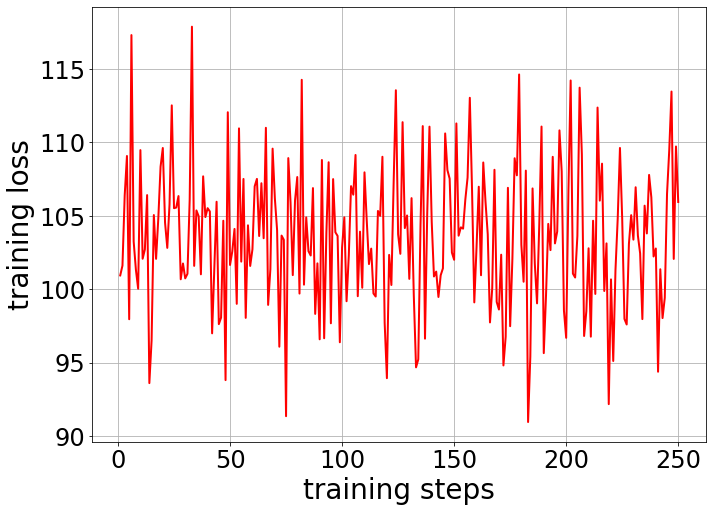

In [8]:
import matplotlib.pyplot as plt
pretrained_network_path = '../models/l1reg_pretrained_nets/'

avg_loss_mye_paired_arr = np.array(avg_loss_mye_paired, dtype=np.float32)
# avg_loss_mye_unpaired_arr = np.load(pretrained_network_path + "avg_loss_mye_unpaired_arr.npy")
np.save(pretrained_network_path + "avg_loss_mye_paired_arr.npy", avg_loss_mye_paired_arr)
train_steps = np.arange(1, 1+avg_loss_mye_paired_arr.size)

# plt.plot(train_steps, avg_loss_mye_paired_arr, 'r', train_steps, avg_loss_acr_unpaired_arr, 'b', linewidth=2.0)
# plt.legend(['paired', 'unpaired'], fontsize=24.0)


plt.plot(train_steps, avg_loss_mye_paired_arr, 'r', linewidth=2.0)

# plt.plot(train_steps, avg_loss_mye_unpaired_arr, 'b', linewidth=2.0)

plt.gcf().set_size_inches(11.0,8.0)
plt.xlabel('training steps', fontsize=28.0)
plt.ylabel('training loss', fontsize=28.0)
plt.tick_params(axis='both', which='major', labelsize=24.0)
plt.grid()

plt.savefig(pretrained_network_path + 'unpaired_train.png', bbox_inches='tight', transparent = False, pad_inches=0.1)
#plt.savefig(pretrained_network_path + 'paired_vs_unpaired_train_combined.png', bbox_inches='tight', transparent = False, pad_inches=0.1)
#plt.savefig(pretrained_network_path + 'paired_train.png', bbox_inches='tight', transparent = False, pad_inches=0.1)

plt.show()

In [ ]:
#check convexity of the net
n_trials = 50
convexity = 0
for trial in np.arange(n_trials):
    x1 = torch.rand(dummy_input.size()).to(device)
    x2 = torch.rand(dummy_input.size()).to(device)
    alpha = torch.rand(1).to(device)

    cvx_combo_of_input = mye(alpha * x1 + (1-alpha)*x2)
    cvx_combo_of_output = alpha * mye(x1) + (1-alpha)*mye(x2)

    convexity += (cvx_combo_of_input.mean() <= cvx_combo_of_output.mean())
if(convexity == n_trials):
    print('the net is %s'%'convex') 
else:
    print('the net is %s'%'non-convex')

In [ ]:
# compare output to exact solution (Does not work yet for this approach)
steps = 1000
x_ij = torch.linspace(start=-0.5, end=0.5,steps=steps)
print((steps,) + real_x[0].shape)
x = torch.zeros((steps,) + real_x[0].shape)
x[:,0,2,3] = x_ij
g_lambda = mye(x)

def soft_shrinkage(el,lamb,alpha):
    if el.abs() <= lamb*alpha:
        return 1/(2*lamb*alpha) * el**2
    else:
        return el.abs() - lamb*alpha/2
        
    
        
gt = np.array([soft_shrinkage(el,alpha,lamb) for el in x_ij])

plt.plot(x_ij.detach().numpy(),g_lambda.detach().numpy())
plt.plot(x_ij.detach().numpy(),gt)
# Plot ground truth

plt.show()